In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
#data loading
train=pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

y=train['label']
x=train.drop(["label"],axis=1)

display(train.head(5))
display(x.head(5))
display(y.head(5))



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [3]:
x = x.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)



In [4]:
from keras.utils import to_categorical
# One-Hot encoding
y = to_categorical(y, num_classes=10)
print(y.shape)


(42000, 10)


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

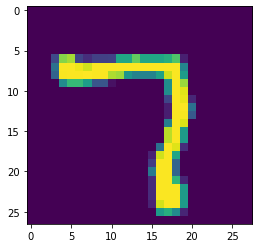

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

i=random.randint(1,42000)
plt.imshow(x[i,1:])
label=y[i]
label

In [6]:
from sklearn.model_selection import train_test_split

x_training, x_validation, y_training, y_validation = train_test_split(x,
                                                                      y,
                                                                      test_size=0.1,
                                                                      shuffle=True)


In [7]:
# data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    zoom_range=0.15, 
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)
data_generator.fit(x_training)

In [8]:
#building cnn
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import tensorflow as tf
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu',
                 input_shape=(28,28,1)))
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation="softmax"))

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [9]:
#training

import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.008):
            print("reached set error")
            self.model.stop_training=True
   


obj=myCallback()
model.fit(x_training,y_training,batch_size=128,epochs=15,verbose=1,
               validation_data=(x_validation,y_validation),callbacks=[obj])


Epoch 1/15
296/296 [==============================] - 9s 22ms/step - loss: 8.0571 - accuracy: 0.5062 - val_loss: 0.1415 - val_accuracy: 0.9550
Epoch 2/15
296/296 [==============================] - 6s 19ms/step - loss: 0.2608 - accuracy: 0.9165 - val_loss: 0.1116 - val_accuracy: 0.9617
Epoch 3/15
296/296 [==============================] - 6s 19ms/step - loss: 0.1677 - accuracy: 0.9481 - val_loss: 0.0821 - val_accuracy: 0.9724
Epoch 4/15
296/296 [==============================] - 6s 19ms/step - loss: 0.1265 - accuracy: 0.9603 - val_loss: 0.0837 - val_accuracy: 0.9745
Epoch 5/15
296/296 [==============================] - 6s 19ms/step - loss: 0.1181 - accuracy: 0.9638 - val_loss: 0.0554 - val_accuracy: 0.9840
Epoch 6/15
296/296 [==============================] - 6s 20ms/step - loss: 0.1108 - accuracy: 0.9672 - val_loss: 0.0530 - val_accuracy: 0.9855
Epoch 7/15
296/296 [==============================] - 6s 19ms/step - loss: 0.0939 - accuracy: 0.9711 - val_loss: 0.0543 - val_accuracy: 0.9850

In [20]:
predictions = model.predict_classes(test, verbose=1)
submission=pd.DataFrame({"ImageId":list(range(1,len(predictions)+1)),
              "Label":predictions})
submission.to_csv("submission file.csv",index=False,header=True)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


875/875 [==============================] - 2s 2ms/step
